<a href="https://colab.research.google.com/github/maxi9113/colab_notebook/blob/main/Taller_Clasification_MLP_Algorith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el procesamiento de bebidas, la aplicación de un determinado conservante es
realizada en función de la combinación de 4 variables reales, definidas por x1 (cantidad
de agua), x2 (grado de acidez), x3 (temperatura) y x4 (tensión superficial). Se sabe, que
solo existen tres tipos de conservantes que pueden ser aplicados, los cuales son
categorizados como A, B y C. A partir de estas variables, se realizan pruebas de
laboratorio para determinar que tipo de conservante debe ser aplicado en determinada
bebida.

De 148 pruebas experimentales, un equipo de expertos decide aplicar una red MLP
como clasificador de patrones, con el fin de que esta identifique que conservante será
aplicado en un determinado lote de bebida. Por las características de la línea de
producción, se utilizará una red con tres salidas


Arquitectura de la red


*   4 Entradas
*   1 capa escodida 15 Neuronas
*   3 Salidas









In [28]:
import pandas as pd

# Leer el archivo CSV en un DataFrame de pandas, usando ';' como separador
X_Data = pd.read_csv('/content/MLP_Clasification.csv', sep=';')

# Eliminar la columna 'Amostra'
X_Data = X_Data.drop('Amostra', axis=1)

# Mostrar las primeras filas del DataFrame para verificar la carga
display(X_Data.head())

,x1,x2,x3,x4,d1,d2,d3
0,"0,3841","0,2021","0,0000","0,2438",1,0,0
1,"0,1765","0,1613","0,3401","0,0843",1,0,0
2,"0,3170","0,5786","0,3387","0,4192",0,1,0
3,"0,2467","0,0337","0,2699","0,3454",1,0,0
4,"0,6102","0,8192","0,4679","0,4762",0,1,0


In [111]:
import numpy as np

# Separar las columnas de entrada (x1 a x4) y salida (d1 a d3)

x_train = X_Data[['x1', 'x2', 'x3', 'x4']].replace(',', '.', regex=True).astype(float).values
desired = X_Data[['d1', 'd2', 'd3']].astype(int).values

# Mostrar las formas de los arrays para verificar
print("Shape of x_train:", x_train.shape)
print("Shape of desired:", desired.shape)

Shape of x_train: (130, 4)
Shape of desired: (130, 3)


Ejecute cinco entrenamientos para la red MLP mostrada en la figura, por medio
del algoritmode aprendizaje backpropagation, inicializando todas las matrices
de pesos con valores aleatorios entre 0 y 1.

In [138]:
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Definir la función de activación y su derivada
def f_activate(x):
    return sigmoidal(x)

def f_derivative(x):
    return sigmoidal_derivative(x)

def sigmoidal(x):
    return 1 / (1 + np.exp(-x))

def sigmoidal_derivative(x):
    return x * (1 - x)

def tanh(x): return np.tanh(x)
def tanh_derivative(y): return 1 - y**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)


# 3. Función para inicializar y entrenar el MLP con arquitectura configurable
def train_mlp_fixed_bias(X, y, hidden_layer_sizes, epochs=100000, learning_rate=0.1, precision_rate=1e-6, max_epoch = 100000, seed=1):
    start = time.time()  # inicio
    np.random.seed(seed)
    input_neurons = X.shape[1]
    output_neurons = y.shape[1]

    weights = []
    biases = [] # Esta lista seguirá almacenando los bias, pero serán fijos en 1

    layer_sizes = [input_neurons] + hidden_layer_sizes + [output_neurons]

    print(f"Arquitectura de la red: {layer_sizes[0]} (entrada) -> {' -> '.join(map(str, hidden_layer_sizes))} (ocultas) -> {layer_sizes[-1]} (salida)")

    # Inicializar pesos y sesgos para todas las capas
    for i in range(len(layer_sizes) - 1):
        w = np.random.uniform(low=-1, high=1, size=(layer_sizes[i], layer_sizes[i+1]))
        # MODIFICACIÓN: Los bias ahora se inicializan a 1 y no se actualizarán
        b = np.random.uniform(low=-0.5, high=0.5, size=(1, layer_sizes[i+1]))
        weights.append(w)
        biases.append(b) # Aunque no se actualice, lo mantenemos en la estructura para el forward pass

    # Lista para almacenar el historial de errores
    loss_history = []
    epoch_history = []


    # 4. Entrenamiento del MLP
    epoch = 0
    while True:
        # Forward Propagation
        layer_outputs = [X]

        for i in range(len(weights)):
            current_input = layer_outputs[-1]
            layer_input_weighted = np.dot(current_input, weights[i]) + biases[i] # Se usa el bias fijo
            layer_output = f_activate(layer_input_weighted)
            layer_outputs.append(layer_output)

        predicted_output = layer_outputs[-1]

        # Backpropagation
        errors = [None] * len(weights)
        deltas = [None] * len(weights)

        error = y - predicted_output
        errors[-1] = error
        deltas[-1] = error * f_derivative(predicted_output)

        for i in range(len(weights) - 2, -1, -1):
            error_current_layer = deltas[i+1].dot(weights[i+1].T)
            errors[i] = error_current_layer
            deltas[i] = error_current_layer * f_derivative(layer_outputs[i+1])

        # Actualizar solo los pesos, los bias permanecen fijos en 1
        for i in range(len(weights)):
            weights[i] += layer_outputs[i].T.dot(deltas[i]) * learning_rate
            biases[i] += np.sum(deltas[i], axis=0, keepdims=True) * learning_rate

        # Imprimir el error
        # Imprimir el error
        loss = np.mean(np.abs(error))
        epoch = epoch+1
        if epoch % 10000 == 0:
            print(f"Época {epoch}, Error medio: {loss:.6f}")

        # Almacenar historial de errores
        loss_history.append(loss)
        epoch_history.append(epoch)

        if loss <= precision_rate or epoch >= max_epoch:
            print(f"✅ Entrenamiento detenido en epoch {epoch + 1} con Loss: {loss:.6f}")
            end = time.time()    # fin
            print(f"Iteración {i+1}, tiempo transcurrido: {end - start:.3f} segundos")
            return weights, biases, epoch_history, loss_history


# --- Ejemplo de uso --
hidden_layer_config = [15] # Aquí configuras tus capas ocultas y neuronas por capa

# Llama a la nueva función que tiene los bias fijos
trained_values = []
training_histories = [] # Lista para almacenar los historiales de cada iteración

for i in range(1,6):
  trained_weights, trained_biases, epoch_history, loss_history = train_mlp_fixed_bias(
      x_train, desired,
      hidden_layer_sizes=hidden_layer_config,
      learning_rate=0.1,
      precision_rate = 1e-6,
      max_epoch = i*20000,
      seed=1
  )
  trained_values.append((trained_weights,trained_biases))
  training_histories.append((epoch_history, loss_history)) # Almacenar el historial de cada iteración



Arquitectura de la red: 4 (entrada) -> 15 (ocultas) -> 3 (salida)
Época 10000, Error medio: 0.026958
Época 20000, Error medio: 0.011817
✅ Entrenamiento detenido en epoch 20001 con Loss: 0.011817
Iteración 2, tiempo transcurrido: 3.152 segundos
Arquitectura de la red: 4 (entrada) -> 15 (ocultas) -> 3 (salida)
Época 10000, Error medio: 0.026958
Época 20000, Error medio: 0.011817
Época 30000, Error medio: 0.006485
Época 40000, Error medio: 0.004142
✅ Entrenamiento detenido en epoch 40001 con Loss: 0.004142
Iteración 2, tiempo transcurrido: 6.142 segundos
Arquitectura de la red: 4 (entrada) -> 15 (ocultas) -> 3 (salida)
Época 10000, Error medio: 0.026958
Época 20000, Error medio: 0.011817
Época 30000, Error medio: 0.006485
Época 40000, Error medio: 0.004142
Época 50000, Error medio: 0.003145
Época 60000, Error medio: 0.002596
✅ Entrenamiento detenido en epoch 60001 con Loss: 0.002596
Iteración 2, tiempo transcurrido: 9.240 segundos
Arquitectura de la red: 4 (entrada) -> 15 (ocultas) -> 3 (

Dado que el problema se configura como un proceso típico de clasificación de
patrones, implemente la rutina que posprocesa las salidas de la red (números
reales) en enteros. Utilice el criterio de redondeo simétrico, es decir:
0,se 0.5

In [ ]:

   # 5. Realizar predicciones después del entrenamiento
def f_activate_threshold(x):
  result = f_activate(x)
  result[result >= 0.5] = 1
  result[result < 0.5] = 0
  return result

 Para cada una de las cinco sesiones de entrenamiento, realice la validación
utilizando el conjunto de prueba proporcionado en la tabla a continuación.
Indique el porcentaje de precisión entre los valores deseados y los valores
proporcionados por la red (tras el posprocesamiento) para todas las muestras
de prueba.

In [191]:
import pandas as pd
import numpy as np

# Leer el archivo CSV en un DataFrame de pandas, usando ';' como separador
X_Data_Predictions = pd.read_csv('/content/MLP_Clasifitacions_Predictions.csv', sep=';')

# Mostrar las primeras filas del DataFrame para verificar la carga

# Separar las columnas de entrada (x1 a x4) y salida (d1 a d3)

x_predictions = X_Data_Predictions[['x1', 'x2', 'x3', 'x4']].replace(',', '.', regex=True).astype(float).values
desired_predictions = X_Data_Predictions[['d1', 'd2', 'd3']].astype(int).values

# Mostrar las formas de los arrays para verificar
print("Shape of x_train:", x_predictions.shape)
print("Shape of desired:", desired_predictions.shape)
display(X_Data.head())

Shape of x_train: (18, 4)
Shape of desired: (18, 3)


,x1,x2,x3,x4,d1,d2,d3
0,"0,3841","0,2021","0,0000","0,2438",1,0,0
1,"0,1765","0,1613","0,3401","0,0843",1,0,0
2,"0,3170","0,5786","0,3387","0,4192",0,1,0
3,"0,2467","0,0337","0,2699","0,3454",1,0,0
4,"0,6102","0,8192","0,4679","0,4762",0,1,0


In [195]:

from IPython.display import display, HTML

def predict(input_data, trained_weights, trained_biases):
  current_output = input_data
  for i in range(len(trained_weights)):
    current_input_weighted = np.dot(current_output, trained_weights[i]) + trained_biases[i]
    current_output = f_activate_threshold(current_input_weighted)
  return current_output,current_input_weighted

# Graficar los resultados

for i, (trained_weights, trained_biases) in enumerate(trained_values):
    print(f"✅ Entrenamiento {i+1} ")
    current_output,current_input_weighted = predict(x_predictions, trained_weights, trained_biases)
    X_Data_Predictions[f'pos_y1'] = current_input_weighted[:, 0].astype(float)
    X_Data_Predictions[f'pos_y2'] = current_input_weighted[:, 1].astype(float)
    X_Data_Predictions[f'pos_y3'] = current_input_weighted[:, 2].astype(float)
    X_Data_Predictions[f'y1'] = current_output[:, 0].astype(int)
    X_Data_Predictions[f'y2'] = current_output[:, 1].astype(int)
    X_Data_Predictions[f'y3'] = current_output[:, 2].astype(int)
    display(HTML(X_Data_Predictions.head(20).to_html()))


✅ Entrenamiento 1 


,x1,x2,x3,x4,d1,d2,d3,pos_y1,pos_y2,pos_y3,y1,y2,y3
0,"0,8622","0,7101","0,6236","0,7894",0,0,1,-24.320454,0.635680,-1.902162,0,1,0
1,"0,2741","0,1552","0,1333","0,1516",1,0,0,22.221959,-19.268270,-42.399804,1,0,0
2,"0,6772","0,8516","0,6543","0,7573",0,0,1,-20.980574,-25.599871,26.720135,0,0,1
3,"0,2178","0,5039","0,6415","0,5039",0,1,0,-13.507598,15.434811,-15.815830,0,1,0
4,"0,7260","0,7500","0,7007","0,4953",0,0,1,-17.577443,3.944376,-1.223638,0,1,0
5,"0,2473","0,2941","0,4248","0,3087",1,0,0,16.600948,-19.526698,-26.942747,1,0,0
6,"0,5682","0,5683","0,5054","0,4426",0,1,0,-13.507598,15.434811,-15.815830,0,1,0
7,"0,6566","0,6715","0,4952","0,3951",0,1,0,-15.310246,4.888055,-10.247427,0,1,0
8,"0,0705","0,4717","0,2921","0,2954",1,0,0,16.397389,-19.519942,-29.258547,1,0,0
9,"0,1187","0,2568","0,3140","0,3037",1,0,0,16.397389,-19.519942,-29.258547,1,0,0


✅ Entrenamiento 2 


,x1,x2,x3,x4,d1,d2,d3,pos_y1,pos_y2,pos_y3,y1,y2,y3
0,"0,8622","0,7101","0,6236","0,7894",0,0,1,-24.835612,0.904705,-6.321294,0,1,0
1,"0,2741","0,1552","0,1333","0,1516",1,0,0,26.459188,-24.496528,-57.208776,1,0,0
2,"0,6772","0,8516","0,6543","0,7573",0,0,1,-24.356482,-30.482276,34.667660,0,0,1
3,"0,2178","0,5039","0,6415","0,5039",0,1,0,-16.652423,23.365138,-27.167533,0,1,0
4,"0,7260","0,7500","0,7007","0,4953",0,0,1,-21.308384,-9.851498,10.968627,0,0,1
5,"0,2473","0,2941","0,4248","0,3087",1,0,0,18.607106,-24.587309,-38.816120,1,0,0
6,"0,5682","0,5683","0,5054","0,4426",0,1,0,-17.333327,22.842864,-24.761271,0,1,0
7,"0,6566","0,6715","0,4952","0,3951",0,1,0,-21.087817,-10.125706,5.623767,0,0,1
8,"0,0705","0,4717","0,2921","0,2954",1,0,0,18.607106,-24.587309,-38.816120,1,0,0
9,"0,1187","0,2568","0,3140","0,3037",1,0,0,18.607106,-24.587309,-38.816120,1,0,0


✅ Entrenamiento 3 


,x1,x2,x3,x4,d1,d2,d3,pos_y1,pos_y2,pos_y3,y1,y2,y3
0,"0,8622","0,7101","0,6236","0,7894",0,0,1,-26.796414,0.134671,-3.632046,0,1,0
1,"0,2741","0,1552","0,1333","0,1516",1,0,0,27.951688,-26.079338,-60.308705,1,0,0
2,"0,6772","0,8516","0,6543","0,7573",0,0,1,-25.443334,-32.894744,37.431170,0,0,1
3,"0,2178","0,5039","0,6415","0,5039",0,1,0,-17.746774,25.366015,-29.356372,0,1,0
4,"0,7260","0,7500","0,7007","0,4953",0,0,1,-23.153157,-12.127198,17.848048,0,0,1
5,"0,2473","0,2941","0,4248","0,3087",1,0,0,19.175304,-26.538067,-41.068204,1,0,0
6,"0,5682","0,5683","0,5054","0,4426",0,1,0,-17.746774,25.366015,-29.356372,0,1,0
7,"0,6566","0,6715","0,4952","0,3951",0,1,0,-21.720167,-9.931612,1.031263,0,0,1
8,"0,0705","0,4717","0,2921","0,2954",1,0,0,19.175304,-26.538067,-41.068204,1,0,0
9,"0,1187","0,2568","0,3140","0,3037",1,0,0,19.175304,-26.538067,-41.068204,1,0,0


✅ Entrenamiento 4 


,x1,x2,x3,x4,d1,d2,d3,pos_y1,pos_y2,pos_y3,y1,y2,y3
0,"0,8622","0,7101","0,6236","0,7894",0,0,1,-26.716778,1.023799,-6.572849,0,1,0
1,"0,2741","0,1552","0,1333","0,1516",1,0,0,28.712757,-26.844689,-61.824156,1,0,0
2,"0,6772","0,8516","0,6543","0,7573",0,0,1,-25.367577,-33.610661,36.187464,0,0,1
3,"0,2178","0,5039","0,6415","0,5039",0,1,0,-18.340177,26.466427,-30.428076,0,1,0
4,"0,7260","0,7500","0,7007","0,4953",0,0,1,-23.197637,-10.930272,12.417412,0,0,1
5,"0,2473","0,2941","0,4248","0,3087",1,0,0,19.505097,-27.438133,-42.157517,1,0,0
6,"0,5682","0,5683","0,5054","0,4426",0,1,0,-18.340177,26.466427,-30.428076,0,1,0
7,"0,6566","0,6715","0,4952","0,3951",0,1,0,-22.346379,-10.425506,1.380667,0,0,1
8,"0,0705","0,4717","0,2921","0,2954",1,0,0,19.450363,-26.283629,-44.280291,1,0,0
9,"0,1187","0,2568","0,3140","0,3037",1,0,0,19.505097,-27.438133,-42.157517,1,0,0


✅ Entrenamiento 5 


,x1,x2,x3,x4,d1,d2,d3,pos_y1,pos_y2,pos_y3,y1,y2,y3
0,"0,8622","0,7101","0,6236","0,7894",0,0,1,-27.143428,1.170718,-6.750531,0,1,0
1,"0,2741","0,1552","0,1333","0,1516",1,0,0,29.205218,-27.294358,-62.791403,1,0,0
2,"0,6772","0,8516","0,6543","0,7573",0,0,1,-25.792575,-34.541643,37.115495,0,0,1
3,"0,2178","0,5039","0,6415","0,5039",0,1,0,-18.761245,27.230713,-31.111751,0,1,0
4,"0,7260","0,7500","0,7007","0,4953",0,0,1,-23.601450,-11.057840,12.581413,0,0,1
5,"0,2473","0,2941","0,4248","0,3087",1,0,0,19.716418,-27.970921,-42.849992,1,0,0
6,"0,5682","0,5683","0,5054","0,4426",0,1,0,-18.761245,27.230713,-31.111751,0,1,0
7,"0,6566","0,6715","0,4952","0,3951",0,1,0,-22.791109,-10.761363,1.635805,0,0,1
8,"0,0705","0,4717","0,2921","0,2954",1,0,0,19.684802,-26.768168,-45.022523,1,0,0
9,"0,1187","0,2568","0,3140","0,3037",1,0,0,19.716418,-27.970921,-42.849992,1,0,0


Para la mejor de las cinco sesiones de entrenamiento realizadas anteriormente,
trace el gráfico respectivo de los valores del error cuadrático medio (MSE) en
función de cada época de entrenamiento.

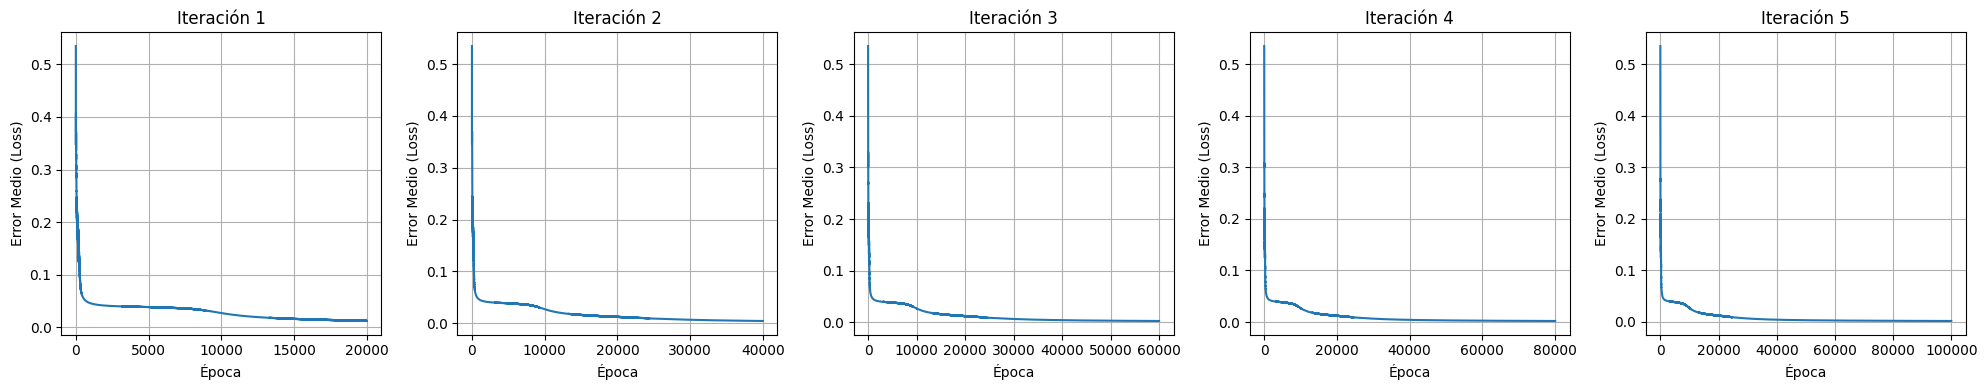

In [180]:
# Graficar los resultados en subplots
plt.figure(figsize=(20, 4)) # Ajusta el tamaño de la figura para que quepan las 5 gráficas en una fila

for i, (epoch_hist, loss_hist) in enumerate(training_histories):
    plt.subplot(1, 5, i + 1) # 1 fila, 5 columnas, posición i+1
    plt.plot(epoch_hist, loss_hist)
    plt.xlabel('Época')
    plt.ylabel('Error Medio (Loss)')
    plt.title(f'Iteración {i+1}')
    plt.grid(True)

plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para que encajen en el área de la figura
plt.show()